# Stellar spectra    A. Basic Line Formation  


**Jakob Borg**

***Instructions*** *This is the template for submitting SSA. Please update your name or student identifier above. Before you submit, make sure you delete all the markdown cells with text in italic (such as these instructions). Do not delete the questions themselves. Write your answers in the cells below the questions. While only one empty cell appears before the question blocks, feel free to add any quantity of cells (code or Markdown) in the order and quantity you see fit. You can also modify the header below to suit your needs, but please don't use any non-standard packages and do not load external code. The whole notebook must run without any errors in the code. In this first experiment with notebooks, there are no page / text limits. But please write concisely, and try to keep it short!*

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

In [2]:
plt.style.use('bmh')
rcconfig = {'font.size'             : 12.0,
            'text.usetex'           : False,
            'text.latex.preamble'   : ('\\usepackage{physics}','\\usepackage{siunitx}'),
            'figure.figsize'        : (8,6),
            'figure.constrained_layout.use'     :True,
            'figure.constrained_layout.h_pad'   :0.07,
            'figure.constrained_layout.w_pad'   :0.05,
            'figure.titlesize'      : 'xx-Large',
            'path.simplify'         : True,
            'legend.frameon'        : True} # I put the frame back on as I like it better with my used style

## USE THIS TO GET THE SAME MATPLOTLIBCONFIGURATIONS AS I HAVE
## IMPORTANT FOR THE LOOK OF FIGURES
for key,val in rcconfig.items():
    mpl.rcParams[key] = val


In [3]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = np.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = np.empty((self.n_stages, self.max_levels))
        chi.fill(np.nan)
        self.g = np.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, np.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature[np.newaxis, np.newaxis]  # to allow broadcast
        return np.nansum(self.g[..., np.newaxis] * 
                            np.exp(-self.chi[..., np.newaxis] / 
                                      constants.k_B / temp), axis=1)
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        pfunc = self.compute_partition_function(temperature)
        # Reshape arrays to allow broadcast
        temp = temperature[np.newaxis, np.newaxis]
        g_ratio = self.g[..., np.newaxis] / pfunc[:, np.newaxis]  # relative to total number of atoms in this stage
        chi = self.chi[..., np.newaxis]
        return g_ratio * np.exp(-chi / (constants.k_B * temp))
    
    def compute_ionisation(self, temperature, electron_pressure):
        """
        Computes ionisation fractions according to the Saha law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2 * np.pi * constants.m_e * constants.k_B * temperature) / 
                      (constants.h ** 2)) ** (3 / 2)
        nstage = np.zeros_like(partition_function) / units.m ** 3
        nstage[0] = 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             np.exp(-self.chi_ion[r + 1, np.newaxis] / 
                                       (constants.k_B * temperature[np.newaxis])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage / np.nansum(nstage, axis=0)

    def compute_populations(self, temperature, electron_pressure):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        return (self.compute_excitation(temperature) * 
                self.compute_ionisation(temperature, electron_pressure)[:, np.newaxis])

    def plot_payne(self, temperature, electron_pressure):
        """
        Plots the Payne curves for the current atom.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        temp = temperature
        ax.plot(np.tile(temp, (self.n_stages, 1)).T, pops[:, 0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(np.tile(temp, (self.n_stages, 1)).T, pops[:, 1].T, 'r--')
        if n_levels > 2:
            ax.plot(np.tile(temp, (self.n_stages, 1)).T, pops[:, 2].T, 'k:')
        ax.set_yscale('log')
        ax.set_ylim(1e-8, 1.1)
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('Populations')

## 1. Saha-Boltzmann calibration of the Harvard sequence ("Cecilia Payne")

## 1.1 Payne’s line strength diagram

## 1.2 The Boltzmann and Saha laws

* Inspect the hydrogen energy level diagram in section 1.2. Which transitions correspond to the hydrogen lines in the image with stellar spectrograms (section 1)? Which transitions share lower levels and which share upper levels?

* Payne's basic assumption was that the strength of the absorption lines observed in stellar spectra scales with the population density of the lower level of the corresponding transition. Why would she think so? (It is not correct, but generally stellar absorption lines do get stronger at larger lower-level population. In this exercise we follow her example and assume that the scaling is linear.)

* Use this expectation to give initial rough estimates of the strength ratios of the $\alpha$ lines in the the H I Lyman, Balmer, Paschen and Brackett series.


__*Answers:*__
  > We can see that the different hydrogen-lines from the stellar spectrograms lie between other lines with noted wavelengths. That is:  
    * $H\delta \in [4026, 4227]Å$  
    * $H\gamma \in [4227, 4472]Å$  
    * $H\beta \in [4472,4954]Å$      
  With the energy level diagram we can conclude that all of these transitions belong in the Balmer series. As the wavelengths lie in the $\sim 400$ nm range. This is consistent with the fact that we know that transitions in the Balmer series corresponds to light in the visible spectrum. This means that all the threee transitions share lower level, $s=2$, but non share upper (as they then would produce the same wavelength).
  
  > Her assumption is understandable. With a high population density in a specific level, say A, there are high chances of transitions from that level actually happening. Thus a lot of photons with the appropriate energies will be absorbed and we see a strong absorption line.
  
  %one would think that many transitions from higher levels down to level A has allready occured. Thus a lot of photons of wavelengths accosiated with level A would have been emitted and we see a high intensity.
  
  > With Payne's expectation, we can give estimates of the ratio of the strength of different spectral lines by looking at the ratio of population density from the Boltzmann law. By looking at the ratio of lines from the same ionisation level we can cancel out the normalization term and the partition function.  
  We write the ratio as  
  $\large \frac{n_{r,s}}{n_{r,t}} = \frac{g_{r,s}e^{-\chi_{r,s}/kT}}{g_{r,t}e^{-\chi_{r,t}/kT}} \overset{r=1}{=} \frac{s^2}{t^2} e^{ (\chi_{1,t}-\chi_{1,s})/kT }$  
    Where we used that the degeneracy of nuetral hydrogen is $g_{1,s} = 2s^2$. The energy levels is defined as $\chi_{1,s} = 13.598(1-s^{-2})$eV, and so we can calculate the ratios and plot them against energy levels. Here we have used the Lyman alpha line ($s=1$) as the base for the ratios, at temperature three different temperatures, plot below.

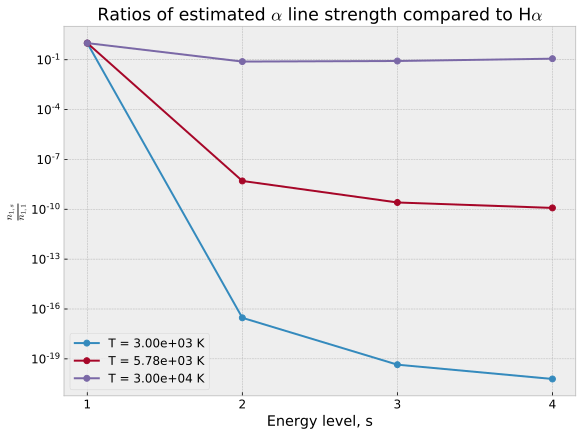

In [4]:
s = np.arange(1,5,1,dtype=float)
k = constants.k_B
T = [3e3,5.777e3,3e4]*units.K
chi = 13.598*(1-s**(-2))*units.eV

# Ratio comparing strengths to the Lyman alpha strength
ratios = (s)**2*np.exp((chi[0]-chi)/(k*T[...,np.newaxis]))

labels = ["T = {:.2e}".format(i) for i in T]
plt.semilogy(s,ratios.T,'o-')
plt.legend(labels)
plt.title(r'Ratios of estimated $\alpha$ line strength compared to H$\alpha$')
plt.xticks(s)
plt.xlabel('Energy level, s')
plt.ylabel(r'$\frac{n_{1,s}}{n_{1,1}}$');

* Explain from equations (1) and (3) why the Saha and Boltzmann distributions behave differently for increasing temperature.
* Speculate how ionisation can fully deplete a stage while excitation puts only a few atoms in levels just below the ionisation level. Hint: what is the limit of the Saha and Boltzman ratios for infinite temperature?

__*Answers:*__

  > The Boltzmann distribution's temperature dependence is only in the exponential term, which for increasing temperature just tends towards 1, $e^{-1/T} \overset{T\rightarrow \infty}{=} 1$.  
  The Saha distribution also have a power law dependence on the temperature in addition to the exponential. While the exponential term tends towards 1 again for increasing temperature, the $T^{3/2} \rightarrow \infty$. Plot of the temperature proportionality below.

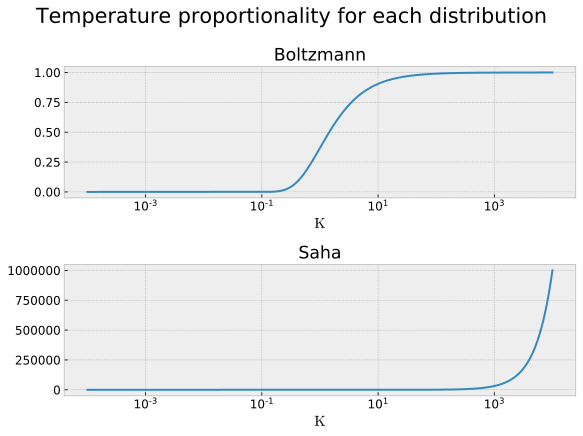

In [5]:
t = np.logspace(-4,4,1000)
fig,ax = plt.subplots(2,1)

ax[0].semilogx(t*units.K,np.exp(-1/t))
ax[1].semilogx(t*units.K,t**(3/2)*np.exp(-1/t));

fig.suptitle('Temperature proportionality for each distribution')
ax[0].set_title('Boltzmann')
ax[1].set_title('Saha');

  > With increasing temperature, the Saha distribution tells us that the fractions of higher ionized stages increases. So with ever increasing temperature we will deplete the lower ionisation stage while populating the higher one. The Boltzmann distribution does not have this element to it, the number of excited electrons in a single atom will not increase for ever, most electrons will still be in the ground state of the given ionisation stage.

## 1.3 Saha-Boltzmann populations of a simplified Ca atom

### 1.3.1 Partition function 

### 1.3.2 Compute the level populations according to the Boltzmann law

### 1.3.3 Compute the ionisation fractions according to the Saha law

### 1.3.4 Put things on an atom class

* Using the simplified Ca atom (`Ca_atom.txt`), compute the partition functions $U_r$ for T=5000, 10000, and 20000 K. What can you say about the temperature dependence of $U_r$?

* Plot a "Payne curve" for the simplified Ca atom using the same temperature range (100 - 175.000 K) and electron pressure (100 Pa)

* Make a separate figure with a Payne curve for an element of your choice. You can choose one of the existing model atoms, or you can use the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/levels_form.html) to build a model for any atom you'd like. How does it compare with Ca?

__*Answers:*__

  > We can see that the temperature dependence is different for each stage, but in general the partition function increases with increasing temperature. Looking at the definition of the partition function, eq (2), we see that for increasing temperature the exponential term goes to one. This means that the partion function is just the sum of the weights, so it goes towards a constant for high temperatures. Plot below.
  
  > Payne plots below. Here I've compared to helium and hydrogen.

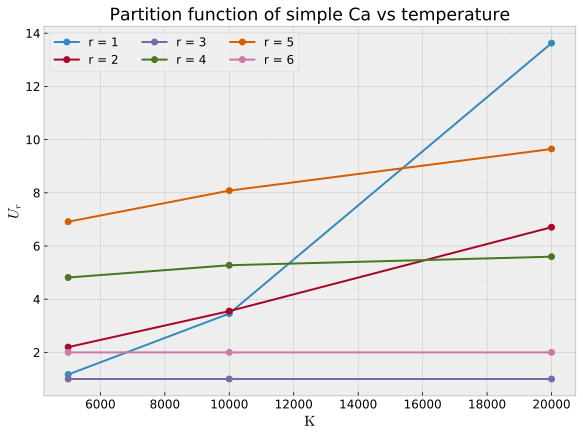

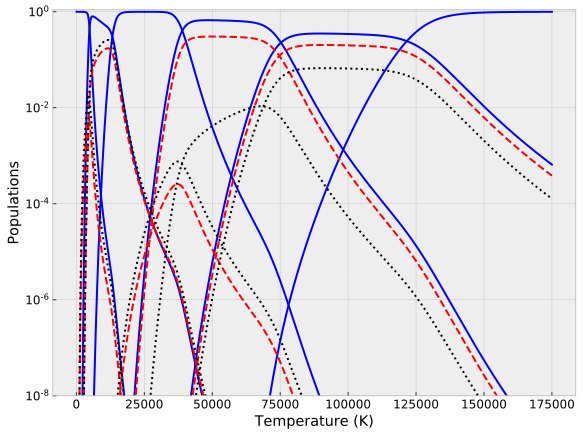

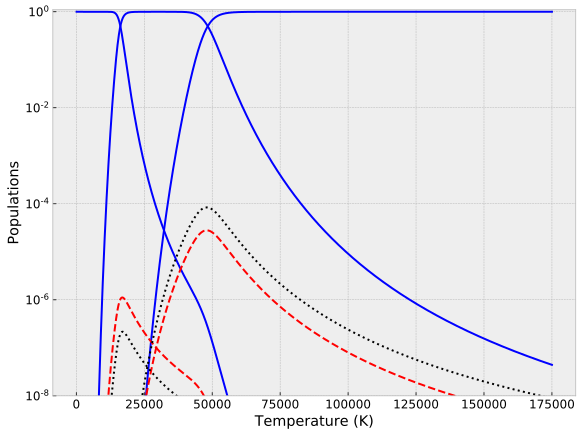

In [7]:
Ca_atom = Atom('Ca_atom.txt')
He_atom = Atom('He_atom.txt')
C_atom = Atom('C_atom.txt')
_temp = [5e3,1e4,2e4]*units.K
temp_continous = np.linspace(100,175e3,1000)*units.K
e_press = 100*units.Pa
Ca_partition = Ca_atom.compute_partition_function(_temp)
#H_part = H_atom.compute_partition_function(_temp)

fig,ax = plt.subplots(1)
labels0 = ['r = {:d}'.format(i) for i in np.arange(1,7)]
ax.plot(_temp,Ca_partition.T,'o-')
ax.set_ylabel(r'$U_r$')
ax.set_title('Partition function of simple Ca vs temperature')
ax.legend(labels0,ncol=3);

Ca_atom.plot_payne(temp_continous,e_press)
He_atom.plot_payne(temp_continous,e_press)

## 1.4 Saha-Boltzmann Populations of Hydrogen

* Using equations (4) and (5), create a model hydrogen atom with 100 levels and save it to a file with the same format. Compute the partition functions for both `H_atom.txt` and your 100-level model. How do they compare?

__*Answer:*__

  > I establish the model and plot the temperature dependence of each below. Here we see that the two ionized stages has a equal and constant partition functions, like we discussed above (note that the red line is not visible as it overlaps precicly with the green one. Meanwhile the partition functions for neutral hydrogen differ a lot as we can see from the logarithmic plot. For our new model with 100 levels we have a much higher valued partition function for temperatures above zero.

### Generating text file and plotting

In [8]:
nr_levels = 100
s = np.linspace(1,nr_levels+1,nr_levels)
r = np.zeros_like(s)

g_1_s = 2*s**2
chi_1_s = 13.598*(1-1/s**2)*units.eV

r[-1] = 1                     # Fix stages for the single ionisation
chi_1_s[-1] = 13.598*units.eV # Fix ionisation energy
g_1_s[-1] = 1                 # Fix ionisation weights

chi_cgs = chi_1_s.to('1/cm',equivalencies=units.spectral())

data = np.array([chi_cgs,g_1_s,r,s]).T
head = '     E (cm^-1)     g    stage   level'
formating = '%14.3f %9.2f %6.i %6.i'
np.savetxt('H_atom_own.txt',data,header = head,fmt=formating)

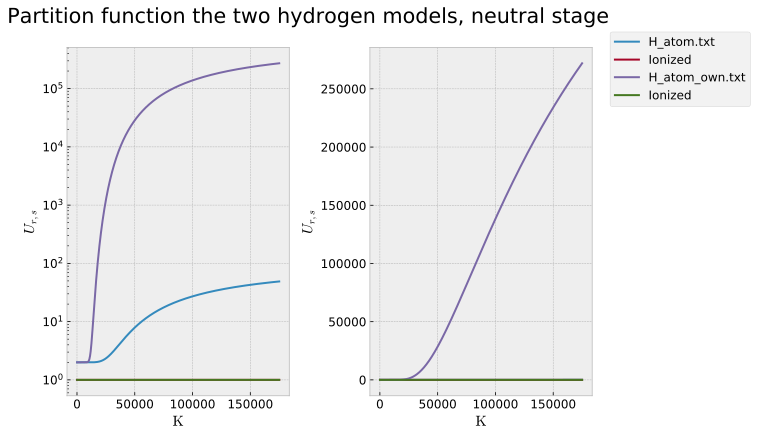

In [9]:
H_atom = Atom('H_atom.txt')
H_atom_own = Atom('H_atom_own.txt')
temp_continous = np.linspace(100,175e3,1000)*units.K
partitions = np.array([H_atom.compute_partition_function(temp_continous),
                       H_atom_own.compute_partition_function(temp_continous)])
partitions = partitions.reshape((4, len(temp_continous)))

fig,ax = plt.subplots(1,2)

ax[0].plot(temp_continous, partitions.T,label='placeholder')
ax[0].set_ylabel(r'$U_{r,s}$')
ax[0].set_yscale('log')

ax[1].plot(temp_continous, partitions.T)
ax[1].set_ylabel(r'$U_{r,s}$')

handles,_ = ax[0].get_legend_handles_labels()
fig.legend(handles,['H_atom.txt','Ionized','H_atom_own.txt','Ionized'],bbox_to_anchor=(1.05,0.95),loc='upper left')
fig.suptitle('Partition function the two hydrogen models, neutral stage');

## 1.5 Solar Ca$^+$K versus H$\alpha$: line strength

* Explain qualitatively why the solar Ca$^+$ K line is much stronger than the solar H$\alpha$ line, even though hydrogen is not ionised in the solar photosphere and low chromosphere ($T \approx$ 4000 - 6000 K) where these lines are formed, and even though the solar Ca/H abundance ratio is only $N_\mathrm{Ca}/N_\mathrm{H} = 2 \times 10^{−6}$. Assume again that the observed line strength scales with the lower-level population density (which it does, although nonlinearly through a "curve of growth" as you will see in an exercise below).

* Prove your explanation by computing and plotting the expected strength ratio of these two lines as function of temperature for $P_e = 10^2$ dyne cm$^{-2}$. Make use of `H_atom.txt` and `Ca_atom.txt`.


__*Answers:*__

  > Assuming line strength scales with the population density of the lower level of the transition, we have that the H$\alpha$ line scales with the population of hydrogen that is excited to the second level. Meanwhile Ca$^+$ K line scales with the population of single ionized calsium in the ground state. This way according to the Boltzmann distribution determining excited states and Saha distribution for ionized stages, even though the abundance of Ca/H is so low, the population of single ionized calsium in the ground state is still higher than the population of neutral hydrogen in the first excited state for the appropriate temperature range. Below are plots of the two populations over a larger temperature range. We see that in $T \in [\sim 4000\text{K}, \sim 6000\text{K}]$ the population of Ca$^+$ is higher than that of the excited hydrogen. For even higher temperatures though, we know from the Saha distribution that the lower ionized stages are depleted so we no longer have that many single ionized calsium atoms. While the Boltzmann distribution tells us that the amount of excited atoms should increase around a specific temperature, which evidently is around $T\sim 10000$K. Here the population of once excited hydrogen is at the maximum, which corresponds to the convex part of the relative line strength.

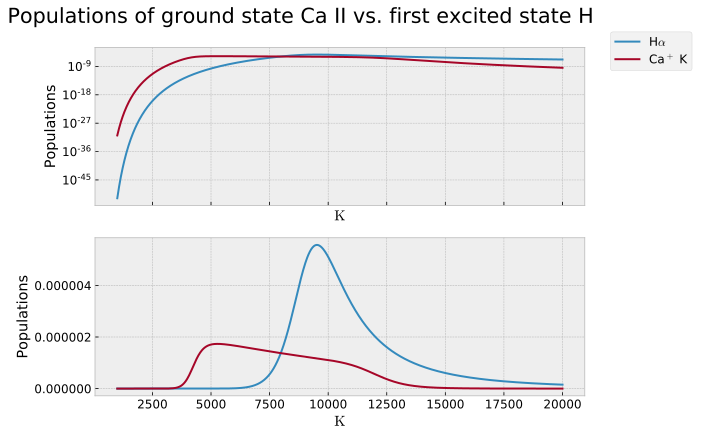

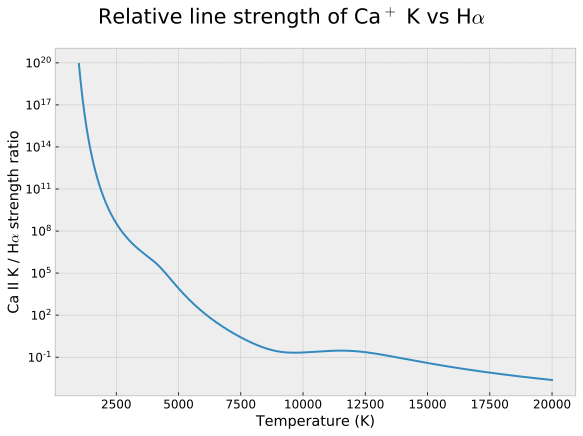

In [10]:
# Reinitialize the objects/variables so not dependent on other cells
H_atom = Atom('H_atom.txt')
Ca_atom = Atom('Ca_atom.txt')
e_press = (10**2 *units.dyne*units.cm**-2).to(units.Pa)
temp_continous = np.linspace(1e3,2e4,1000)*units.K
Ca_abundance = 2e-6

H_pop = H_atom.compute_populations(temp_continous,e_press)[0,1]   # The population of neutral H in the first excited state
Ca_pop = Ca_atom.compute_populations(temp_continous,e_press)[1,0] # The first ionized Ca population, ground state
Ca_pop *= Ca_abundance
Ca_H_ratio = Ca_pop/H_pop

fig,ax = plt.subplots(2,1,sharex=True)

ax[0].plot(temp_continous,np.array([H_pop,Ca_pop]).T,label='placeholder')
ax[0].set_ylabel('Populations')
ax[0].set_yscale('log')

ax[1].plot(temp_continous,np.array([H_pop,Ca_pop]).T)
ax[1].set_ylabel('Populations')

handles,_ = ax[0].get_legend_handles_labels()
fig.legend(handles,[r'H$\alpha$',r'Ca$^+$ K'],bbox_to_anchor=(1.05,0.95),loc='upper left')
fig.suptitle(r'Populations of ground state Ca II vs. first excited state H')

fig,ax = plt.subplots()
ax.plot(temp_continous, Ca_H_ratio)
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Ca II K / H$\alpha$ strength ratio');
fig.suptitle(r'Relative line strength of Ca$^+$ K vs H$\alpha$');

## 1.6 Solar Ca$^+$K versus H$\alpha$: temperature sensitivity

* Plotting the relative population changes $(\Delta n_\mathrm{Ca} / \Delta T) / n_\mathrm{Ca}$ and $(\Delta n_\mathrm{H} /  \Delta T) / n_\mathrm{H}$ for the lower levels of Ca$^+$K and H$\alpha$, using $\Delta T=$ 1 K.

* Around $T=$ 5600 K the Ca$^+$K curve dips down to very  small values; the H$\alpha$ curve does that around $T=$ 9500  K. Thus, for $T \approx$ 5600 K the temperature sensitivity of Ca$^+$K is much smaller than the temperature sensitivity of H$\alpha$. Each dip has a $\Delta n > 0$ and a $\Delta n < 0$ flank.  Which is which? (The dips can be diagnosed by overplotting the variation with temperature of each population in relative units.) 

* Explain each flank of the two population curves and the dips in the two temperature sensitivity curves.

* Find at which temperature the hydrogen in stellar photospheres with $P_e =$ 10 Pa is about 50% ionised. Plot the neutral and ionised fractions of hydrogen as a function of temperature.

__*Answers:*__

  > To generate the required plots I've reused the code given in SSA, but swapped around the logarithmic axis to better visualize the dips in the temperature dependence and how they relate to the relative populations, as well as some changes to better match my style. I've also included a plot of the sign of each $\Delta n$. We note that the left flank of each dip in the temperature sensitivity has $\Delta n > 0$ and the right one has $\Delta n < 0$.  
  A $\Delta n > 0$ corresponds to a temperature region where the population increases with increasing temperature. The opposite is true for $\Delta n < 0$, increasing the temperature causes the population to decrease. We see that the temperature sensitivity is the lowest for each line where the relative population is the highest. We know from the Saha distribution that specific stages gets populated at specific temperatures, and then depleted again with even higher temperatures. This happens at lower temperatures for calsium than for hydrogen as the ionisation energy are higher in the latter, approximatly doubled. At around $T\approx5600$ K we maximize the relative population of the first ionized stage of calsium, and then for higher temperatures it gets further ionized to Ca II (Ca$^{++}$) and so the population decreases again. The higher ionisation energy of hydrogen causes this relative population maxima at a higher temperature $T\approx 9600$ K, where we also know from the Boltzmann law that the population of excited states will increase, but that this effect is not as decisive as the change from ionisation. So we get a higher population of excited hydrogen, before we start ionizing it and deplete the stage so that the population is decreasing.

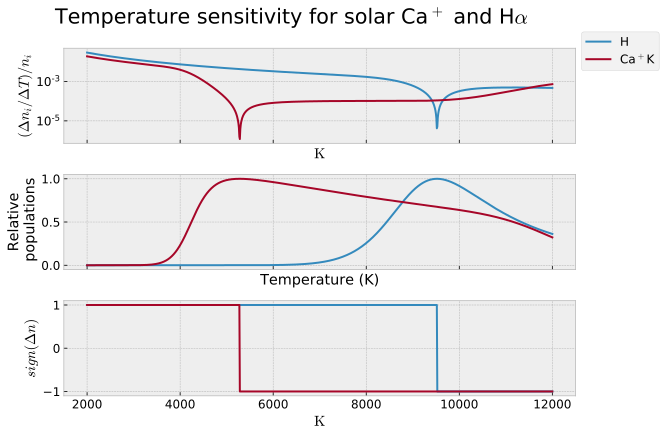

In [11]:
e_press = 10 * units.Pa
temp = np.linspace(2000, 12000, 1000) * units.K
dT = 1 * units.K

ca_atom = Atom("Ca_atom.txt")
n_ca1 = ca_atom.compute_populations(temp, e_press)[1, 0]
n_ca2 = ca_atom.compute_populations(temp - dT, e_press)[1, 0]
diff_ca = (n_ca1 - n_ca2) / (dT * n_ca1)

h_atom = Atom("H_atom.txt")
n_h1 = h_atom.compute_populations(temp, e_press)[0, 1]
n_h2 = h_atom.compute_populations(temp - dT, e_press)[0, 1]
diff_h = (n_h1 - n_h2) / (dT * n_h1)

fig, ax = plt.subplots(nrows=3,sharex=True)
ax[0].plot(temp, np.abs(diff_h), label=r'H')
ax[0].plot(temp, np.abs(diff_ca), label=r'Ca$^+$K')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$(\Delta n_i / \Delta T) / n_i$')

ax[1].plot(temp, n_h1 / n_h1.max())
ax[1].plot(temp, n_ca1 / n_ca1.max())
ax[1].set_ylabel('Relative\n populations')
ax[1].set_xlabel('Temperature (K)')

ax[2].plot(temp, np.sign(diff_h), label=r'H')
ax[2].plot(temp, np.sign(diff_ca), label=r'Ca$^+$K')
ax[2].set_ylabel(r'$sign(\Delta n)$')

fig.suptitle(r'Temperature sensitivity for solar Ca$^+$ and H$\alpha$')
handles,labels = ax[0].get_legend_handles_labels()
fig.legend(handles,labels,bbox_to_anchor=(1.,0.95),loc='upper left');

## 2. Fraunhofer line strengths and the curve of growth ("Marcel Minnaert")

    
### 2.1 The Planck law

* Plot the Planck function $B_\lambda$ for 100 $< \lambda <$ 2000 nm for a range of temperatures (5000 to 8000 K). Use a log scale for both the x and y axes. Explain the slopes of the righthand part.

__*Answers:*__

  > On the right hand side of the maximum, the slopes follow the Wien-approximation. In the lecture notes I can only find expressions for this in the frequency scale, either I'm misinterpreting the notation or there are typos. But I've double checked with expressions online, which states it as $$I_\lambda^{Wien} = \frac{2hc^2}{\lambda^5}e^{\frac{-hc}{\lambda kT}}$$ I've calculated the slope to be $\sim -3.7$, which is not $-5$ but is tending towards it. I've also printed the value of the "Boltzmann factor", which should go to one for large wavelengths. But because of the other constants and temperature the wavelength is not large enough, so the factor as value $\sim 0.4$. This means that the region where the slope is going as $\lambda^{-5}$ is not yet reached.

Slope right hand side -3.481076304785334
Max value of boltzmann factor 0.40688046024908336


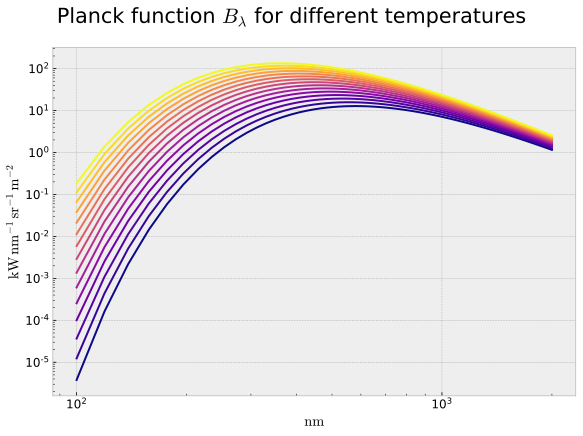

In [12]:
from astropy.modeling.blackbody import blackbody_lambda
from astropy.modeling.blackbody import blackbody_nu
i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

wave = np.linspace(100, 2000, 100) * units.nm
temp = np.linspace(5000, 8000, 15) * units.K

# Extend wave and temp to calculate blackbody radiation all at once
radiation = blackbody_lambda(wave[:, np.newaxis], temp[np.newaxis]).to(i_units)

max_rad_log = np.log(radiation[:,-1].to_value())
wave_log = np.log(wave.to_value())
slope_right_log = (max_rad_log[-1]-max_rad_log[-2])/(wave_log[-1]-wave_log[-2])
print('Slope right hand side', slope_right_log)
print('Max value of boltzmann factor',np.exp(-constants.h*constants.c/wave[-1]/constants.k_B/temp[-1]))

fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0, 1, len(temp))))
ax.set_prop_cycle(custom_cycler)  # optional, change default colours of plots
ax.plot(wave, radiation.to(i_units))
#ax.plot(wave[id_wave_right],max_rad[id_wave_right],'o')
ax.set_xscale('log')
ax.set_yscale('log')
fig.suptitle(r'Planck function $B_\lambda$ for different temperatures');

### 2.2 Radiation through an isothermal layer

* Use equation (11) to calculate the radiation through an isothermal layer. Make plots of $I_\lambda$ for the different values of $I_\lambda(0)$, using the following values:

``` python
b_lambda = 2
tau = np.logspace(-2, 1, 100)
i0 = np.arange(5)
```
    
* How does $I_\lambda$ depend on $\tau$ for $\tau \ll 1$ when $I_\lambda(0) =0$ (hint: use a log scale in the x and y axes to study the behavior at small $\tau$)?  And when $I_\lambda(0) > B_\lambda$? Such a layer with $\tau \ll 1$ is called "optically thin", why? Would "radiatively thin" be a better name?
 
* A layer is called "optically thick" when it has $\tau \gg 1$. Why? The emergent intensity becomes independent of $\tau$ for large $\tau$. Can you explain why this is so in physical terms? 

__*Answers:*__

  > Plots for the different initial intensities below. We see how they all converge towards the value of $B_\lambda = 2$ for higher optical thickness.
  
  > For the $I_\lambda(0)=0$ case, we see from the log-log plot for $\tau \ll 1$ that the the intensity is a power law of the $\tau$, close to linear with log-log slope $\sim0.98$. Meanwhile, for the $I_\lambda(0)>B_\lambda$ cases the intensity is close a constant, with slope $\sim -0.012$. This region is called optically thin as the intensity of the incoming light is not attenuated much. By inspecting the case with zero incoming intensity, we see that we still observe intensity coming out the other end. For this case "radiatively thin" would maybe be a better name, but not so much for the $I_\lambda > B_\lambda$ case.
  
  > For a layer with $\tau \gg 1$ we see from the plot that the observed intensity is independent on the incoming intensity. The radiation tends towards $B_\lambda$ for $\tau \sim 4$, the radiation intensity emitted by a black body. This way we can say that layers with $\tau \gg 1$ are optically thick as we cannot see "through" the layer, or we cannot see what is going on behind it, because we only se the intensity from the layer it self. The optical depth can also be thought of as the grade of opaqueness. For $\tau\gg 1$ we only see radiation from the layers which are closest to the surface. The intensity then would not depend on $\tau$ anymore as the radiation we observe is only coming from the outmost layer.

slope low tau 0.9806358797123731
slope high tau -0.012556596354416789


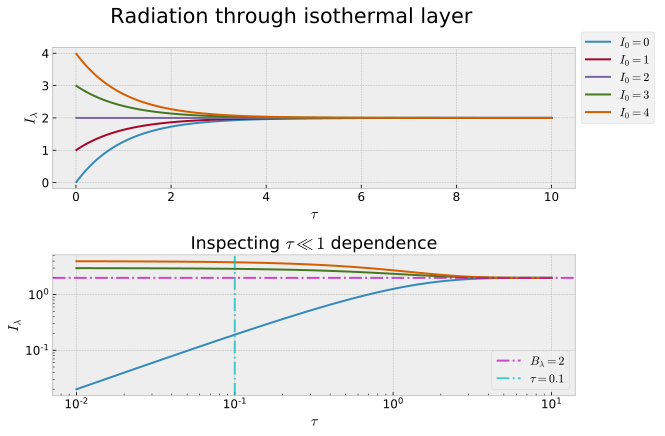

In [13]:
B_lambda = 2
tau = np.logspace(-2,1,100)
I0 = np.arange(5)

I = I0[:,np.newaxis]*np.exp(-tau) + B_lambda*(1-np.exp(-tau))
id_small_tau = np.argmin(np.abs(tau-0.1))

I_log = np.log(I)
tau_log = np.log(tau)
slope_0 = (I_log[0,id_small_tau]-I_log[0,0])/(tau_log[id_small_tau]-tau_log[0])
slope_3 = (I_log[3,id_small_tau]-I_log[3,0])/(tau_log[id_small_tau]-tau_log[0])
print('slope low tau',slope_0)
print('slope high tau',slope_3)


fig,ax = plt.subplots(2,1)

ax[0].plot(tau,I.T,label='placeholder')

ax[1].loglog(tau,I[0])#,label=r'$I_\lambda(0)=0$')
ax[1].loglog(tau,I[3],color='C3')#,label=r'$I_\lambda(0)=3>B_\lambda$')
ax[1].loglog(tau,I[4],color='C4')#,label=r'$I_\lambda(0)=4>B_\lambda$')
ax[1].axhline(B_lambda,linestyle='-.',color='m',alpha=0.7,label=r'$B_\lambda = 2$')
ax[1].axvline(0.1,linestyle='-.',color='c',alpha=0.7,label=r'$\tau = 0.1$')
ax[1].legend()
ax[1].set_title(r'Inspecting $\tau\ll 1$ dependence')

for eax in ax.flatten():
    eax.set_ylabel(r'$I_\lambda$')
    eax.set_xlabel(r'$\tau$')

fig.suptitle('Radiation through isothermal layer')
handles,_ = ax[0].get_legend_handles_labels()
fig.legend(handles,[r'$I_0 = {:d}$'.format(i) for i in I0],bbox_to_anchor=(1.,0.95),loc='upper left');

## 2.3 Spectral lines from a solar reversing layer


### 2.3.1 Schuster-Schwarzschild model

### 2.3.2 Voigt profile

### 2.3.3 Emergent line profiles

* Compute and plot the emergent line profiles using a Schuster-Schwarzschild model, using the code provided. Try changing the parameters (`temp_surface`, `temp_layer`, `a`, `tau0`) to see if you can obtain a saturated line profile (flat bottom). Which parameter(s) are more important in determining this?

* Make a plot of line profiles with different $\tau_0$, using `tau0 = 10 ** np.linspace(-2, 2, 9)`. How do you explain the profile shapes for $\tau(0) \ll 1$? Why is there a low-intensity saturation limit for $\tau \gg 1$? Why do the line wings develop only for very large $\tau(0)$? Where do the wings end? For which values of $\tau(0)$ is the layer optically thin, respectively optically thick, at line center? And at $u=5$?

* Now study the dependence of these line profiles on wavelength by repeating the above for $\lambda=$ 200 nm (ultraviolet) and $\lambda=$ 1000 nm (near infrared). What sets the top value $I_{\rm cont}$ and the limit value reached at line center by $I(0)$? Check these values by computing them directly. What happens to these values at other wavelengths?  

* Make a figure with plots for the above: line profiles for several values of $\tau_0$, and the three different wavelengths (200, 500, and 1000 nm). However, normalise each line profile by its continuum intensity: `intensity /= intensity[0]` (observed spectra are usually normalised this way because absolute calibrations are often missing). Explain the wavelength dependencies in this plot.

__*Answers:*__

  > Below I've experimenting with different combinations of the parameters to see how they effect the line profiles. I initially guess that the optical thickness is the most significant parameter, so I plot for different values of $\tau$ while experimenting with each of the other parameters individually. As we can see a high optical thickness is required for saturated profiles. We also so that the saturation intensity is determined by the layer temperature, from the stipled lines. For the case with varying layer temperatures I calculate different black body intensities for each, and note that the different lines saturates at appropriate intensities. 
  
  > For $\tau(0)\ll 1$ we see that the profile shapes are less changed by passing through the layer. For the 0.001 case the profile is barely showing. As discussed, these are cases where the seperate layer is close to transparent, and doesn't affect the emittation from the surface so much. The saturation limit for high $\tau$ is due to the intensity of the radiation emitted by the seperate layer it self. It can't limit the initial intensity to lower values than this, as it is the layers "source intensity".
  
  > If I understand the question correctly, the line wings develope for the large $\tau_0$s because of the large broadening effect from a opaque seperate layer. Arguably, the lower $\tau_0$s also got wings, but the asymptotic behavior is less noticable. This is due to the Voigt function, which is the convolution between a Gaussian and a Lorentz profile. For low $\tau_0$ the profile is so small that we only see the effect near the center of the line, where it is mostly Gaussian. For the larger $\tau_0$ the profile is more profound and we are able to see more of the Lorentzian part of the Voigt function. The intensity is dependent on $\tau_\lambda$ like $e^{-\tau_\lambda}$, which is asymptotic in behavior. The intensity doesn't really reach the continuum intensity before $u \rightarrow \pm \infty$. I've plotted it with a logarithmic too for a large range of unitless wavelengths. We can see that effectivly the wings end at around $u=10$.  
  We define the boarder between optically thick and thin by $\tau=1$, which corresponds to the intensity where the continuum intensity is reduced by a factor of $1/e$, which I've plotted as a dashed blue line. In the center we can read that the cases with $\tau < 1$ is above the line, and is hence optically thin, and $\tau >1$ is the opposite, as expected. For wavelengths at $u=5$ all the different profiles is considered optically thin.
  
  > The top value is found by inserting $\tau=0$, then  $I_\lambda = I_{cont} = I_C = B_\lambda(T_{surface})$ is set by the Planck function, as we have assumed that the surface radiates in a contiuous spectre without spectral lines. The Planck function, as we know, is dependent on wavelength, and so the $I_C$ will be different for the two wavelengths. In the plot I've estimated $I_C$ by using the value for $I(\tau\sim 0, u=-10)$.  
  The limit reached at the center of the line is set by the seperate layer's source function, or by letting $\tau\rightarrow \infty$, resulting in $I_{min} = B_\lambda(T_{layer})$, which also is dependent on wavelength.  
  These values are highly dependent on wavelength, as we can see through the Planck function. So these values vary wildly for different $\lambda$.
  
  > Lastly, from the normalised plots over different wavelengths, we can see that the wavelength dependency is in the saturation level. The higher wavelengths are saturated at a higher relative intensity than the lower ones. So higher energy radiation is evidently more obstructed by the seperate layer than lower energy wavelengths.

### Experimenting with different parameters and combinations.

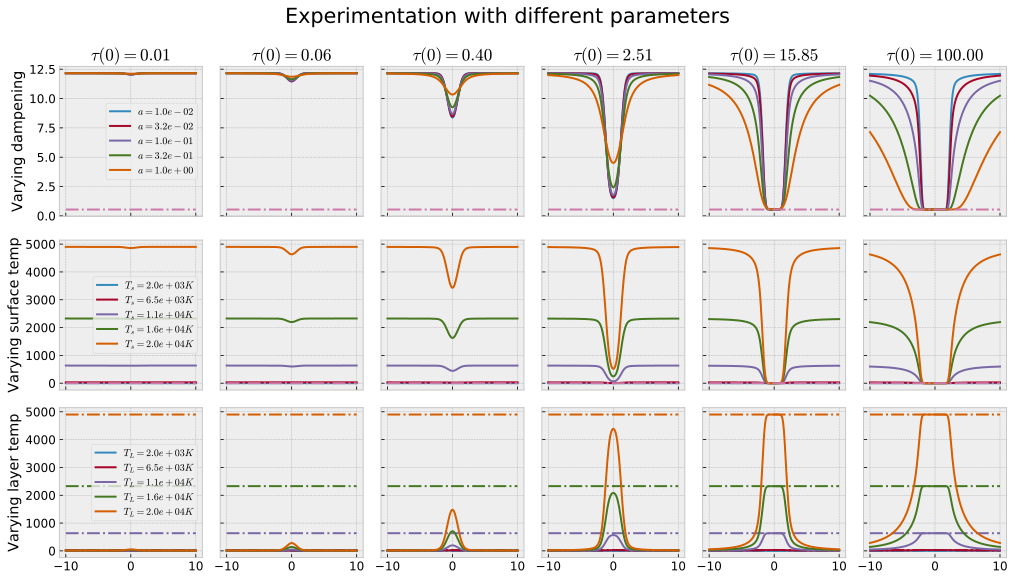

In [41]:
from scipy.special import wofz

def voigt(damping, u):
    """
    Calculates the Voigt function.
    """
    z = (u + 1j * damping)
    return wofz(z).real

def compute_profile(tau0, a, u, wavelength,temp_surface,temp_layer):
    wave = wavelength[np.newaxis, np.newaxis]
    tau = tau0[np.newaxis] * voigt(a, u[:, np.newaxis])
    tau = tau[..., np.newaxis]
    result = (blackbody_lambda(wave, temp_surface) * np.exp(-tau) +
              blackbody_lambda(wave, temp_layer) * (1 - np.exp(-tau)))
    return np.squeeze(result)

temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
wave = units.Quantity(300, unit='nm')
tau0 = np.array([1.])  # thickness of reversing layer

a = 0.1   # Damping parameter
u = np.linspace(-10, 10, 201)

nr_taus = 6
fig, ax = plt.subplots(3,nr_taus,sharex=True,sharey='row',figsize=(14,8))
a_s = np.logspace(-2,0,5)
temp_surface_s = np.linspace(2e3,2e4,5)*units.K
temp_layer_s = np.linspace(2e3,2e4,5)*units.K
tau_s = np.logspace(-2,2,nr_taus)
# intensity from black body from layer with given temp. plotted as the stipled lines in the figure.
# this way i can see at which temperatures the saturation is happening.
bb = blackbody_lambda(wave,temp_layer).to(i_units)*np.ones_like(u)

# This is not optimized at all, I just wanted to throw together a lot of different combinations
for i,_tau in enumerate(tau_s):
    intensity = compute_profile(_tau, a_s, u, wave,temp_surface,temp_layer)
    ax[0,i].plot(u, intensity.to(i_units))
    ax[0,i].plot(u,bb,'-.',label='BB')
    
    ax[0,i].set_title(r'$\tau(0) = {:.2f}$'.format(_tau))
    ax[0,0].set_ylabel('Varying dampening')   
    ax[0,0].legend([r'$a={:.1e}$'.format(j) for j in a_s],fontsize=10)


    intensity = compute_profile(_tau, a, u, wave,temp_surface_s,temp_layer)
    ax[1,i].plot(u, intensity.to(i_units))
    ax[1,i].plot(u,bb,'-.')
    ax[1,0].legend([r'$T_s={:.1e}$'.format(j) for j in temp_surface_s],fontsize=10)
    ax[1,0].set_ylabel('Varying surface temp')   
    
    for j,temp_layer in enumerate(temp_layer_s):
        intensity = compute_profile(_tau, a, u, wave,temp_surface,temp_layer)
        # different black body intensity from different layer temperatures
        bb_ = blackbody_lambda(wave,temp_layer).to(i_units)*np.ones_like(u)
        ax[2,i].plot(u, intensity.to(i_units),label=r'$T_L={:.1e}$'.format(temp_layer),color='C{}'.format(j))
        ax[2,i].plot(u,bb_*np.ones_like(u),'-.',color='C{}'.format(j))
    ax[2,0].set_ylabel('Varying layer temp')
    ax[2,0].legend(fontsize=10)
    temp_layer = 4200 * units.K # Reset temp_layer
    
    if i>0:
        for k in range(3):
            ax[k,i].set_ylabel('')

fig.suptitle('Experimentation with different parameters');

### Studing line profiles and their wings with different tau 

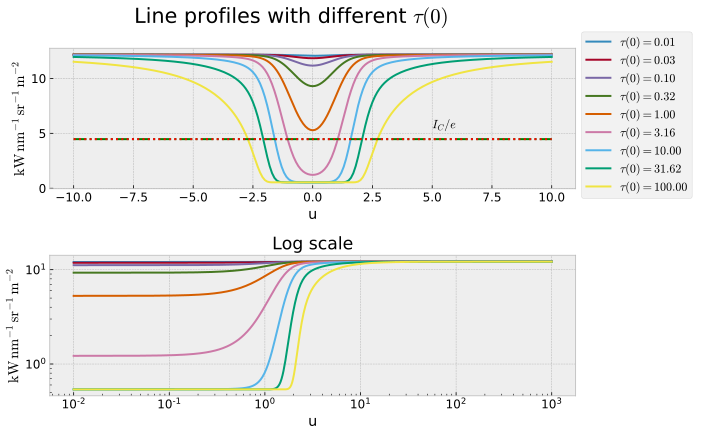

In [35]:
temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
wave = units.Quantity(300, unit='nm')
tau0 = np.logspace(-2,2,9)
a = 0.1   # Damping parameter
u = np.linspace(-10, 10, 201)
u_log = np.logspace(-2,3,500)

intensity = compute_profile(tau0,a,u,wave,temp_surface,temp_layer).to(i_units)
intensity_log = compute_profile(tau0,a,u_log,wave,temp_surface,temp_layer).to(i_units)

# To show that the continuum and my estimates are approximatly equal I
# calculate both and plot them for this case
init_intensity = blackbody_lambda(wave,temp_surface).to(i_units)
thick_boarder = init_intensity/np.exp(1)
thick_boarder2 = intensity[0,0]/np.exp(1)

fig,ax = plt.subplots(2)
ax[0].plot(u,intensity,label='placeholder')
ax[0].plot(u,thick_boarder*np.ones_like(u),'g-.')
ax[0].plot(u,thick_boarder2*np.ones_like(u),'r:')
ax[0].text(5,thick_boarder+1*units.kW/units.m/units.m/units.nm/units.sr,r'$I_C/e$')
ax[0].set_xlabel('u')

ax[1].loglog(u_log,intensity_log)
ax[1].set_xlabel('u')
ax[1].set_title('Log scale')

handles, _ = ax[0].get_legend_handles_labels()
fig.legend(handles,[r'$\tau(0)={:.2f}$'.format(i) for i in tau0],bbox_to_anchor=(1.,0.95),loc='upper left');
fig.suptitle(r'Line profiles with different $\tau(0)$');

### Studing line profiles with different tau and wavelength = 200 and 1000
#### Also looking at values for cont and saturation intensities

Lambda = 200.0 nm
I_C    = 12.16 kW / (m2 nm sr)
I(0)   =  1.44 kW / (m2 nm sr)  for  tau = 0.01
I(0)   =  1.41 kW / (m2 nm sr)  for  tau = 0.03
I(0)   =  1.33 kW / (m2 nm sr)  for  tau = 0.10
I(0)   =  1.10 kW / (m2 nm sr)  for  tau = 0.32
I(0)   =  0.60 kW / (m2 nm sr)  for  tau = 1.00
I(0)   =  0.10 kW / (m2 nm sr)  for  tau = 3.16
I(0)   =  0.01 kW / (m2 nm sr)  for  tau = 10.00
I(0)   =  0.01 kW / (m2 nm sr)  for  tau = 31.62
I(0)   =  0.01 kW / (m2 nm sr)  for  tau = 100.00
Lambda = 1000.0 nm
I_C    = 12.16 kW / (m2 nm sr)
I(0)   = 10.70 kW / (m2 nm sr)  for  tau = 0.01
I(0)   = 10.57 kW / (m2 nm sr)  for  tau = 0.03
I(0)   = 10.18 kW / (m2 nm sr)  for  tau = 0.10
I(0)   =  9.09 kW / (m2 nm sr)  for  tau = 0.32
I(0)   =  6.76 kW / (m2 nm sr)  for  tau = 1.00
I(0)   =  4.40 kW / (m2 nm sr)  for  tau = 3.16
I(0)   =  4.01 kW / (m2 nm sr)  for  tau = 10.00
I(0)   =  4.00 kW / (m2 nm sr)  for  tau = 31.62
I(0)   =  4.00 kW / (m2 nm sr)  for  tau = 100.00
Lambda = 500.0 nm
I_C    = 12

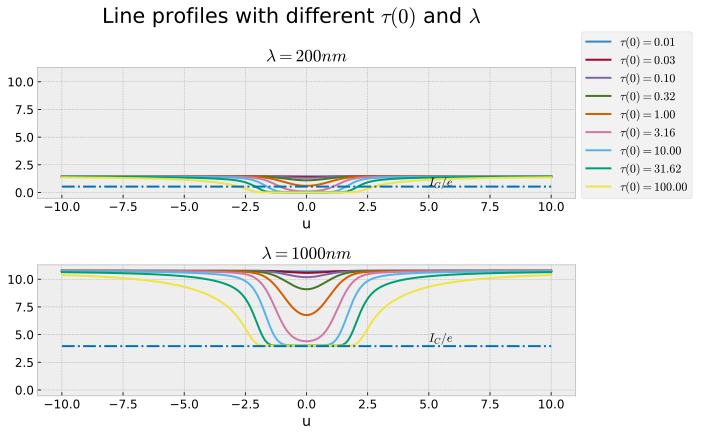

In [42]:
nr_tau = 9
temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
tau0 = np.logspace(-2,2,nr_tau)
a = 0.1   # Damping parameter
u = np.linspace(-10, 10, 201)
waves = np.array([200,1000,500,2000,50])*units.nm

fig,ax = plt.subplots(2,sharey=True)
for i,wave in enumerate(waves):
    intensity = compute_profile(tau0,a,u,wave,temp_surface,temp_layer).to(i_units)
    thick_boarder = intensity[0,0]/np.exp(1)
    if i<2:
        ax[i].plot(u,intensity,label='placeholder')
        ax[i].plot(u,thick_boarder*np.ones_like(u),'-.')
        ax[i].text(5,thick_boarder+units.Quantity(thick_boarder/10,unit=i_units),r'$I_C/e$')
        ax[i].set_xlabel('u')
        ax[i].set_title(r'$\lambda = {:.0f}$'.format(wave))
        ax[i].set_ylabel('')
    
    print('Lambda = {}'.format(wave))
    print('I_C    = {:5.2f}'.format(init_intensity))
    for i in range(nr_tau):
        print(r'I(0)   = {:5.2f}  for  tau = {:.2f}'.format(intensity[int(intensity.shape[0]/2),i],tau0[i]))

handles, _ = ax[0].get_legend_handles_labels()
fig.legend(handles,[r'$\tau(0)={:.2f}$'.format(i) for i in tau0],bbox_to_anchor=(1.,0.95),loc='upper left');
fig.suptitle(r'Line profiles with different $\tau(0)$ and $\lambda$');

### Normalised profiles with different tau and wavelength = 200,500 and 1000

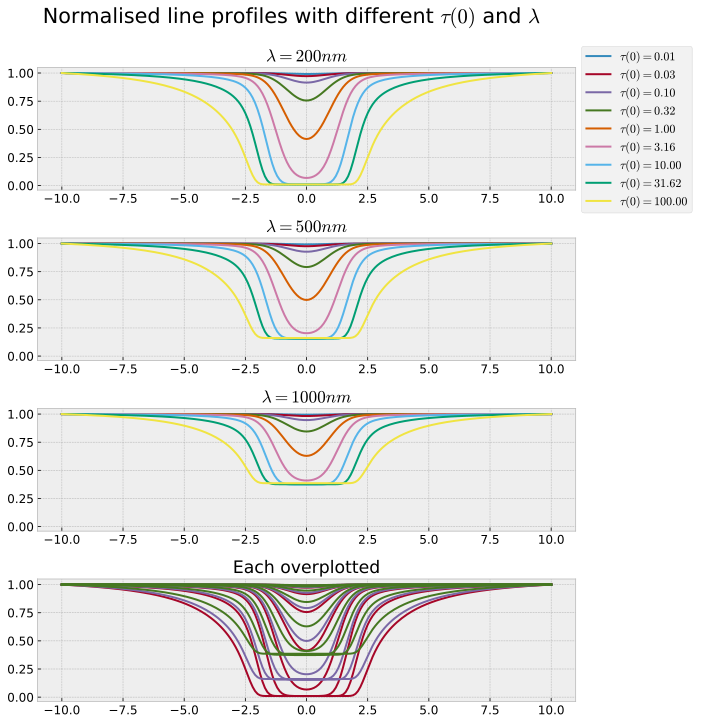

In [37]:
nr_tau = 9
temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
tau0 = np.logspace(-2,2,nr_tau)
a = 0.1   # Damping parameter
u = np.linspace(-10, 10, 201)
waves = np.array([200,500,1000])*units.nm

fig,ax = plt.subplots(waves.shape[0]+1,sharey=True,figsize=(8,10))
for i,wave in enumerate(waves):
    intensity = compute_profile(tau0,a,u,wave,temp_surface,temp_layer).to(i_units)
    intensity /= intensity[0]

    ax[i].plot(u,intensity,label='placeholder')
    ax[i].set_title(r'$\lambda = {:.0f}$'.format(wave))
    ax[i].set_ylabel('')
    
    ax[-1].plot(u,intensity,color='C{}'.format(i+1))
ax[-1].set_title('Each overplotted')

handles, _ = ax[0].get_legend_handles_labels()
fig.legend(handles,[r'$\tau(0)={:.2f}$'.format(i) for i in tau0],bbox_to_anchor=(1.,0.95),loc='upper left');
fig.suptitle(r'Normalised line profiles with different $\tau(0)$ and $\lambda$');

## 2.4 The equivalent width of spectral lines


## 2.5 The curve of growth

* Compute and plot a curve of growth by plotting $W_\lambda$ against $\tau_0$ on a log-log plot. Explain what happens in the three different parts.  

* The first part has slope 1:1, the third part has slope 1:2 in this log-log plot.  Why?

* Which parameter controls the location of the onset of the third part? Give a rough estimate of its value for solar iron lines through comparison with the given figure from Wright (1948).

* Which parameter should you increase to produce emission lines instead of absorption lines? Change it accordingly and modify the code to produce emission profiles and an emission-line curve of growth. (To avoid taking the log of negative $W_\lambda$, plot the absolute value of $W_\lambda$.)

__*Answers:*__

  > I've scetched the three different parts by the dashed vertical lines, where $\tau = 1$ and $\tau = 100$. In the first part, with $\tau\ll 1$, the medium is optically thin and the amount of spectral blocking is growing linearly. In the middle we have a transition region from optically thin to thick. In the last part the medium is optically thick, and the line profile would be saturated.  
  In the first part for low $\tau$ values we know the profile is growing linearly with $\tau$, so the slope in this log-log plot will be $1$. This corresponds to the profiles where the Gaussian part of the Voigt function is dominating, and so the area of the absorption lines increase linearly.  
  In the middle part the profile hits the saturation limit, and the area of the line stops increasing linearly.  
  In the third part the slope is $\sim 0.5$, this corresponds to where the profile is growing in area by the wings developing from the Lorentzian distribution. While the area still grows, due to the saturation of the line it grows much slower than for lower $\tau$.
  
  > I expect the dampening parameter $a$ to be the decisive paramter for the location of the third part. To test this I experiment with the Voigt profile for different $a$-values and plot it in log-log scales. Here the effect of the dampening parameter is evident in the location of the transition between the Gaussian bell and Lorentzian wing regime. Knowing this I experiment with the curve of growth in the same way. Here I calculate the slope at the end of the curve for each a, just to check if it is close to $\sim 0.5$, which indeed is the case. I also mark $\tau_0 = 1$ transition line. I also mark the $\tau_0 = 10$ line, which is ment to correspond to the transition to the third part in the solar curve of growth from Wrigth (1948), which I happens at around $\log (X_F) = 1$. The other parameters will also tune how this curve looks, but I don't change any of these parameters from the ones given in the code examples.  
  By inspecting the plot we are able to give a rough estimate of the dampening parameter that gives a curve of growth with onset of the third part at around $\tau = 10$. The shape of my curve is not identical, but only judging by the location of the onset it looks like this is around $a \sim 0.32$.
  
  > To get emission lines instead of absortion line we need to "invert the role" of the seperate layer, which is responsible for the spectral lines. As we saw from the experimentation with different sets of parameters in part 2.3.3, we were able to produce emission lines by setting the temperature of the layer to be higher than the surface. I plot the emission lines for some of the $\tau$ values for increasing $a$ together with the hole curve of growth, where we take the absolute value of the equivalent width. Here we see that the shape of the curve of growth is identical. This is due to the emission and absorption lines being symmetrical along the continuum intensity.

a 0.1
slope 0.4370196149854191


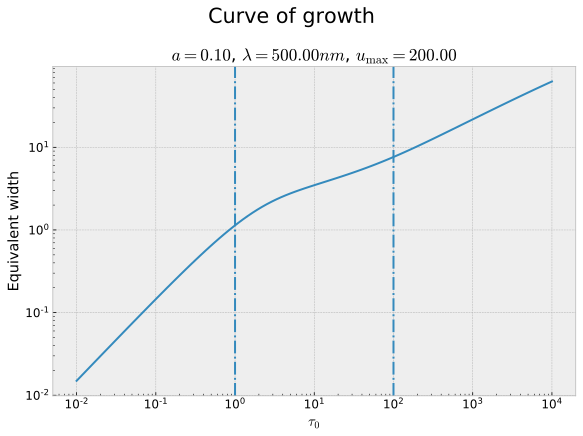

In [38]:
temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
tau0 = np.logspace(-2, 4, 101)
wave = units.Quantity(500, unit='nm')
u = np.linspace(-200, 200, 1000)
a = 0.1

intensity = compute_profile(tau0, a, u, wave,temp_surface,temp_layer)
intensity /= intensity[0]  # normalise 

# Now we must specify axis because intensity is a 2D array
equivalent_width = np.trapz(1 - intensity, x=u, axis=0)
eqw = np.log(equivalent_width)
slope = (eqw[-1]-eqw[-2])/(np.log(tau0[-1])-np.log(tau0[-2]))
print('a',a)
print('slope',slope)

fig, ax = plt.subplots()
ax.plot(tau0, equivalent_width)
ax.axvline(1,linestyle='-.')
ax.axvline(100,linestyle='-.')
ax.set_xlabel(r'$\tau_0$')
ax.set_ylabel('Equivalent width')
ax.set_xscale('log')
ax.set_yscale('log');
ax.set_title(r'$a = {:.2f}$, $\lambda = {:.2f}$, $u_\max = {:.2f}$'.format(a,wave,u.max()))
fig.suptitle('Curve of growth');

# Experimenting with the Voigt profile

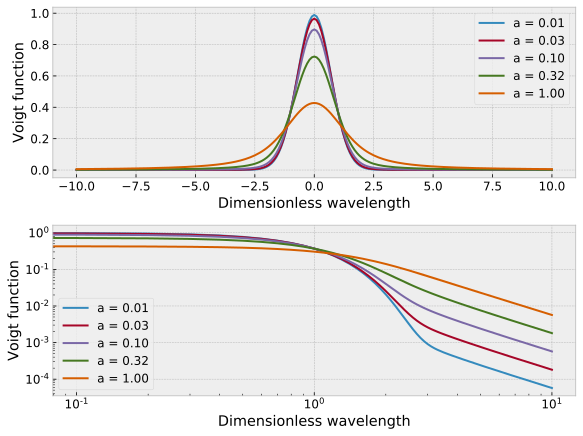

In [19]:
u = np.linspace(-10,10,201)
fig, ax = plt.subplots(2,1)
legend_elements = ['a = %4.2f' % value for value in a_s]

ax[0].plot(u, voigt(a_s[np.newaxis], u[:, np.newaxis]))
ax[0].legend(legend_elements)
ax[1].plot(np.abs(u), voigt(a_s[np.newaxis], u[:, np.newaxis]))
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(legend_elements)

for ax in ax.flatten():
    ax.set_ylabel('Voigt function')
    ax.set_xlabel('Dimensionless wavelength');

## Experimenting with curve of growth

a     =      0.01
slope =      0.36
a     =      0.02
slope =      0.42
a     =      0.03
slope =      0.46
a     =      0.06
slope =      0.47
a     =      0.10
slope =      0.47
a     =      0.18
slope =      0.47
a     =      0.32
slope =      0.46
a     =      0.56
slope =      0.45
a     =      1.00
slope =      0.44


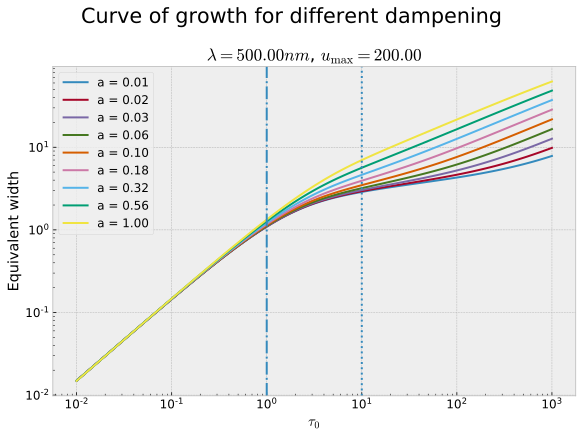

In [84]:
temp_surface = 5777 * units.K
temp_layer = 4200 * units.K
tau0 = np.logspace(-2, 3, 101)
wave = units.Quantity(500, unit='nm')
u = np.linspace(-200, 200, 1000)
a_s = np.logspace(-2,0,9)

fig, ax = plt.subplots()

for i,a in enumerate(a_s):
    intensity = compute_profile(tau0, a, u, wave,temp_surface,temp_layer)
    intensity /= intensity[0]  # normalise 
    # Now we must specify axis because intensity is a 2D array
    equivalent_width = np.trapz(1 - intensity, x=u, axis=0)
    eqw = np.log(equivalent_width)
    slope = (eqw[-1]-eqw[-2])/(np.log(tau0[-1])-np.log(tau0[-2]))
    print('{:5s} = {:9.2f}'.format('a',a))
    print('{:5s} = {:9.2f}'.format('slope',slope))

    ax.plot(tau0, equivalent_width,label='a = {:.2f}'.format(a))

ax.legend()
ax.axvline(1,linestyle='-.')
ax.axvline(10,linestyle=':')
ax.set_xlabel(r'$\tau_0$')
ax.set_ylabel('Equivalent width')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r'$\lambda = {:.2f}$, $u_\max = {:.2f}$'.format(wave,u.max()))
fig.suptitle('Curve of growth for different dampening');

### Emission lines

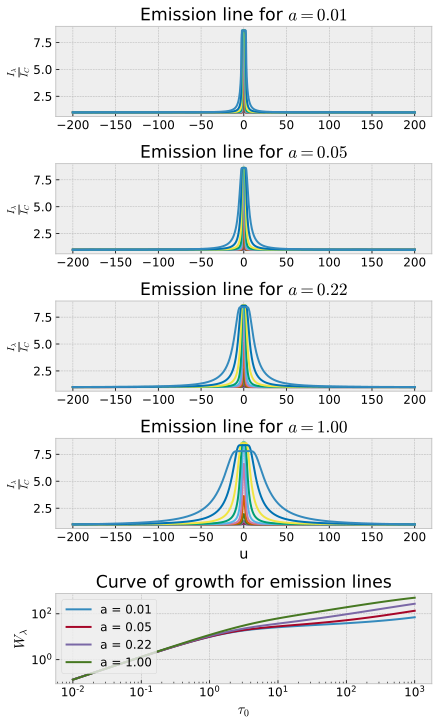

In [85]:
temp_surface = 5777 * units.K
temp_layer = 1e4 * units.K
tau0 = np.logspace(-2, 3, 101)
wave = units.Quantity(500, unit='nm')
u = np.linspace(-200, 200, 1000)
a_s = np.logspace(-2,0,4)

fig, ax = plt.subplots(len(a_s)+1,1,figsize=(6,10))

for i,a in enumerate(a_s):
    intensity = compute_profile(tau0, a, u, wave,temp_surface,temp_layer)
    intensity /= intensity[0]  # normalise 
    # Now we must specify axis because intensity is a 2D array
    equivalent_width = np.trapz(1 - intensity, x=u, axis=0)
    ax[-1].loglog(tau0, np.abs(equivalent_width),label='a = {:.2f}'.format(a))
    ax[i].plot(u,intensity[:,::10])
    ax[i].set_title(r'Emission line for $a = {:.2f}$'.format(a))
    
for axis in ax[0:-1]:
    axis.set_ylabel(r'$\frac{I_\lambda}{I_C}$')
ax[-2].set_xlabel('u')
ax[-1].set_xlabel(r'$\tau_0$')
ax[-1].set_ylabel(r'$W_\lambda$')
ax[-1].legend()
ax[-1].set_title('Curve of growth for emission lines');